In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
trainX = np.load("/content/gdrive/MyDrive/archive/ProcessedData/trainX.npy").astype(np.float32)
trainY = np.load("/content/gdrive/MyDrive/archive/ProcessedData/trainY.npy").astype(np.float32)
testX = np.load("/content/gdrive/MyDrive/archive/ProcessedData/testX.npy").astype(np.float32)
testY = np.load("/content/gdrive/MyDrive/archive/ProcessedData/testY.npy").astype(np.float32)

In [ ]:
trainX.shape

(241, 512, 512)

In [ ]:
trainX = (trainX-127.0)/127.0
testX = (testX-127.0)/127.0
trainY = (trainY>127).astype(np.float32)
testY = (testY>127).astype(np.float32)

In [ ]:
print(trainX.dtype)
print(trainY.dtype)
print(testX.dtype)
print(testY.dtype)

float32
float32
float32
float32


In [ ]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX:",trainX.shape)
print("trainY:",trainY.shape)
print("testX:",testX.shape)
print("testY:",testY.shape)

trainX: (241, 512, 512, 1)
trainY: (241, 512, 512, 1)
testX: (61, 512, 512, 1)
testY: (61, 512, 512, 1)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')

    #Encoder
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    #BottleNeck
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(conv5)

    #Decoder
    up6 = concatenate([Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding="same")(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(conv6)

    up7 = concatenate([Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), padding="same")(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(conv7)

    up8 = concatenate([Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), padding="same")(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(conv8)

    up9 = concatenate([Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), padding="same")(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(1, (1,1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
weight_path="checkpoint-{epoch:03d}-{val_dice_coef:.3f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                   patience=2,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=18)

CALLBACKS = [checkpoint, early, reduceLROnPlat]

In [ ]:
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
history = model.fit(x = trainX,
                    y = trainY,
                    batch_size = 16,
                    epochs = 100,
                    validation_data =(testX,testY),
                    callbacks=CALLBACKS
                  )

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: -0.7405 - dice_coef: 0.7481 - binary_accuracy: 0.9996
Epoch 1: val_loss improved from -0.72850 to -0.73775, saving model to checkpoint-001-0.740.hdf5
16/16 [==============================] - 17s 1s/step - loss: -0.7405 - dice_coef: 0.7481 - binary_accuracy: 0.9996 - val_loss: -0.7378 - val_dice_coef: 0.7399 - val_binary_accuracy: 0.9997 - lr: 6.8600e-05
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: -0.7513 - dice_coef: 0.7085 - binary_accuracy: 0.9997
Epoch 2: val_loss did not improve from -0.73775
16/16 [==============================] - 17s 1s/step - loss: -0.7513 - dice_coef: 0.7085 - binary_accuracy: 0.9997 - val_loss: -0.7305 - val_dice_coef: 0.7327 - val_binary_accuracy: 0.9997 - lr: 6.8600e-05
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: -0.7579 - dice_coef: 0.7696 - binary_accuracy: 0.9997
Epoch 3: val_loss improved from -0.73775 to -0.74135, saving model to check

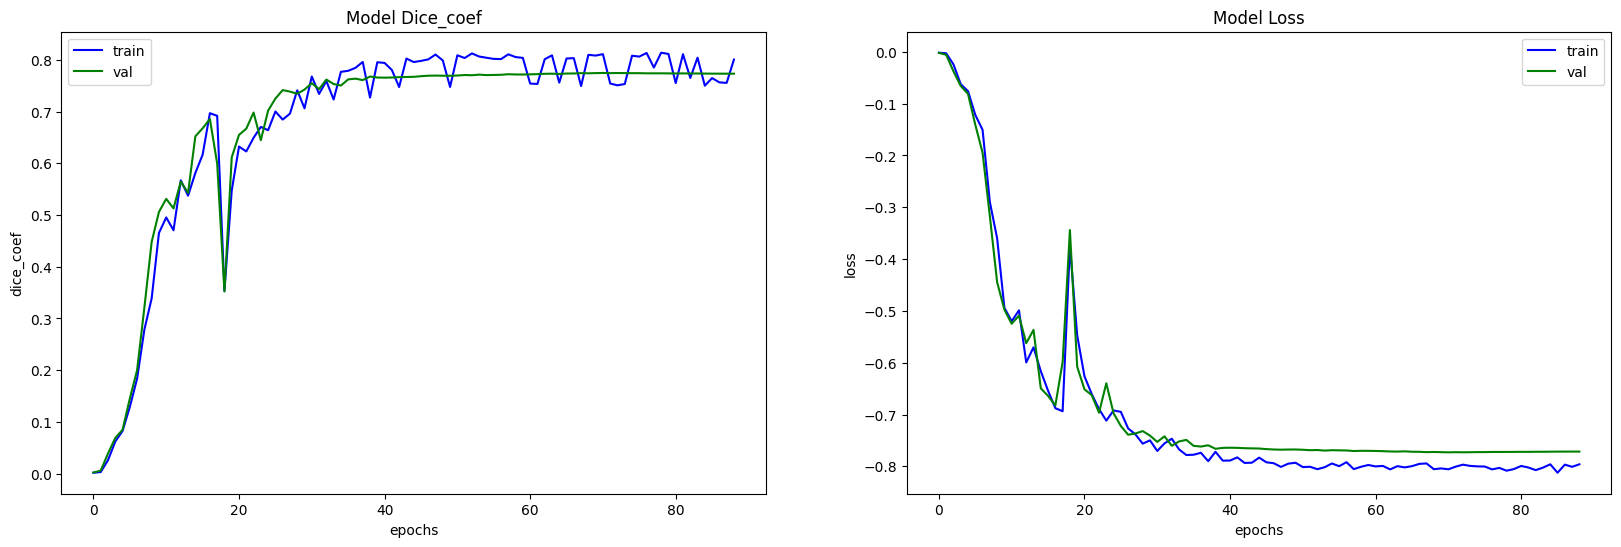

In [ ]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['dice_coef', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [ ]:
import pickle
with open('LC_UNet_trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
model.save("UNet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(testX, testY)

2/2 [==============================] - 51s 25s/step - loss: -0.7867 - dice_coef: 0.7875 - binary_accuracy: 0.9997


[-0.786710798740387, 0.7875498533248901, 0.999713122844696]

In [ ]:
model2 = unet(input_size=(512,512,1))
model2.load_weights("checkpoint-071-0.775.hdf5")

model2.compile(optimizer=Adam(learning_rate=2e-4),
                loss=[dice_coef_loss],
                metrics = [dice_coef, 'binary_accuracy'])

model2.evaluate(testX, testY)

2/2 [==============================] - 2s 513ms/step - loss: -0.7878 - dice_coef: 0.7887 - binary_accuracy: 0.9997


[-0.7877946496009827, 0.7886589765548706, 0.9997154474258423]

In [ ]:
model2.save("UNet_best_Model_checkpoint.h5")

In [ ]:
j = 1
for i in range(30, min(80, len(testX))):  # Adjust the loop range
    test = np.squeeze(testX)[i]
    t_p = model2.predict(np.reshape(test, (1, 512, 512, 1)))

    plt.figure(figsize=(20, 300))
    plt.subplot(50, 3, j)
    plt.imshow(np.squeeze(test), cmap="bone")
    plt.subplot(50, 3, j + 1)
    plt.imshow(np.squeeze(t_p), cmap="gray")
    plt.subplot(50, 3, j + 2)
    plt.imshow(cv2.addWeighted(np.squeeze(test), .5, np.squeeze(t_p), .5, 0), cmap="gray")
    j += 3

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!mkdir -p /content/gdrive/MyDrive/archive/Training_Logs


In [ ]:
!cp UNet.h5 /content/gdrive/MyDrive/archive/Training_Logs/UNet.h5
!cp LC_UNet_trainHistory /content/gdrive/MyDrive/archive/Training_Logs/UNet_trainHistory

In [ ]:
!cp UNet_best_Model_checkpoint.h5 /content/gdrive/MyDrive/archive/Training_Logs/UNet_best_Model_checkpoint.h5